## Utkarsh Joshi 
 
### Summary of Learnings

- Recursive Feature Elimination (RFE) helps in selecting the most relevant features by iteratively removing the least important ones.

- GridSearchCV automates hyperparameter tuning using K-Fold Cross-Validation, improving model generalization.

- Combining RFE with GridSearchCV allows for both optimal feature selection and parameter tuning, leading to better model accuracy.

🚀 This notebook showcases my learning and hands-on experimentation with these techniques!

In [1]:
from pathlib import Path
import pandas as pd
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")


C:\Users\91788\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def load_breast_cancer_data():
    # Define file paths
    data_path = Path("datasets/wdbc.data")
    
    # Check if the file exists; if not, download it
    if not data_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
        urllib.request.urlretrieve(url, data_path)
    
    # Load the data into a DataFrame
    column_names = [
        "id", "diagnosis", "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean",
        "compactness_mean", "concavity_mean", "concave_points_mean", "symmetry_mean", "fractal_dimension_mean",
        "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se", "compactness_se",
        "concavity_se", "concave_points_se", "symmetry_se", "fractal_dimension_se", "radius_worst",
        "texture_worst", "perimeter_worst", "area_worst", "smoothness_worst", "compactness_worst",
        "concavity_worst", "concave_points_worst", "symmetry_worst", "fractal_dimension_worst"
    ]
    
    # Read the dataset
    data = pd.read_csv(data_path, header=None, names=column_names)
    
    
    data.drop(columns=["id"], inplace=True)
    
    return data


In [3]:

# Load the breast cancer dataset
breast_cancer_data = load_breast_cancer_data()

# Display first few rows
breast_cancer_data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
breast_cancer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave_points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [5]:
breast_cancer_data['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [6]:
breast_cancer_data.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [7]:
# Convert the diagnosis column to binary format (M = 1, B = 0)
breast_cancer_data['diagnosis'] = breast_cancer_data['diagnosis'].map({'M': 1, 'B': 0})

#### Feature Selection

Since we are not sure which specific features will be most suitable for modeling, various feature selection techniques can be used. Here, I am applying Recursive Feature Elimination (RFE) to iteratively remove less important features and identify the most relevant ones.

I am using both Random Forest and Decision Tree for feature selection:

Random Forest is well-suited for high-dimensional data and provides more stable feature importance rankings by averaging importance scores across multiple trees, reducing sensitivity to data variations.
Decision Tree is also considered because the dataset is relatively small, and it allows for a direct, interpretable comparison of feature importance.
By using both methods, I can compare the feature selection outcomes and ensure that the best set of features is chosen for modeling.

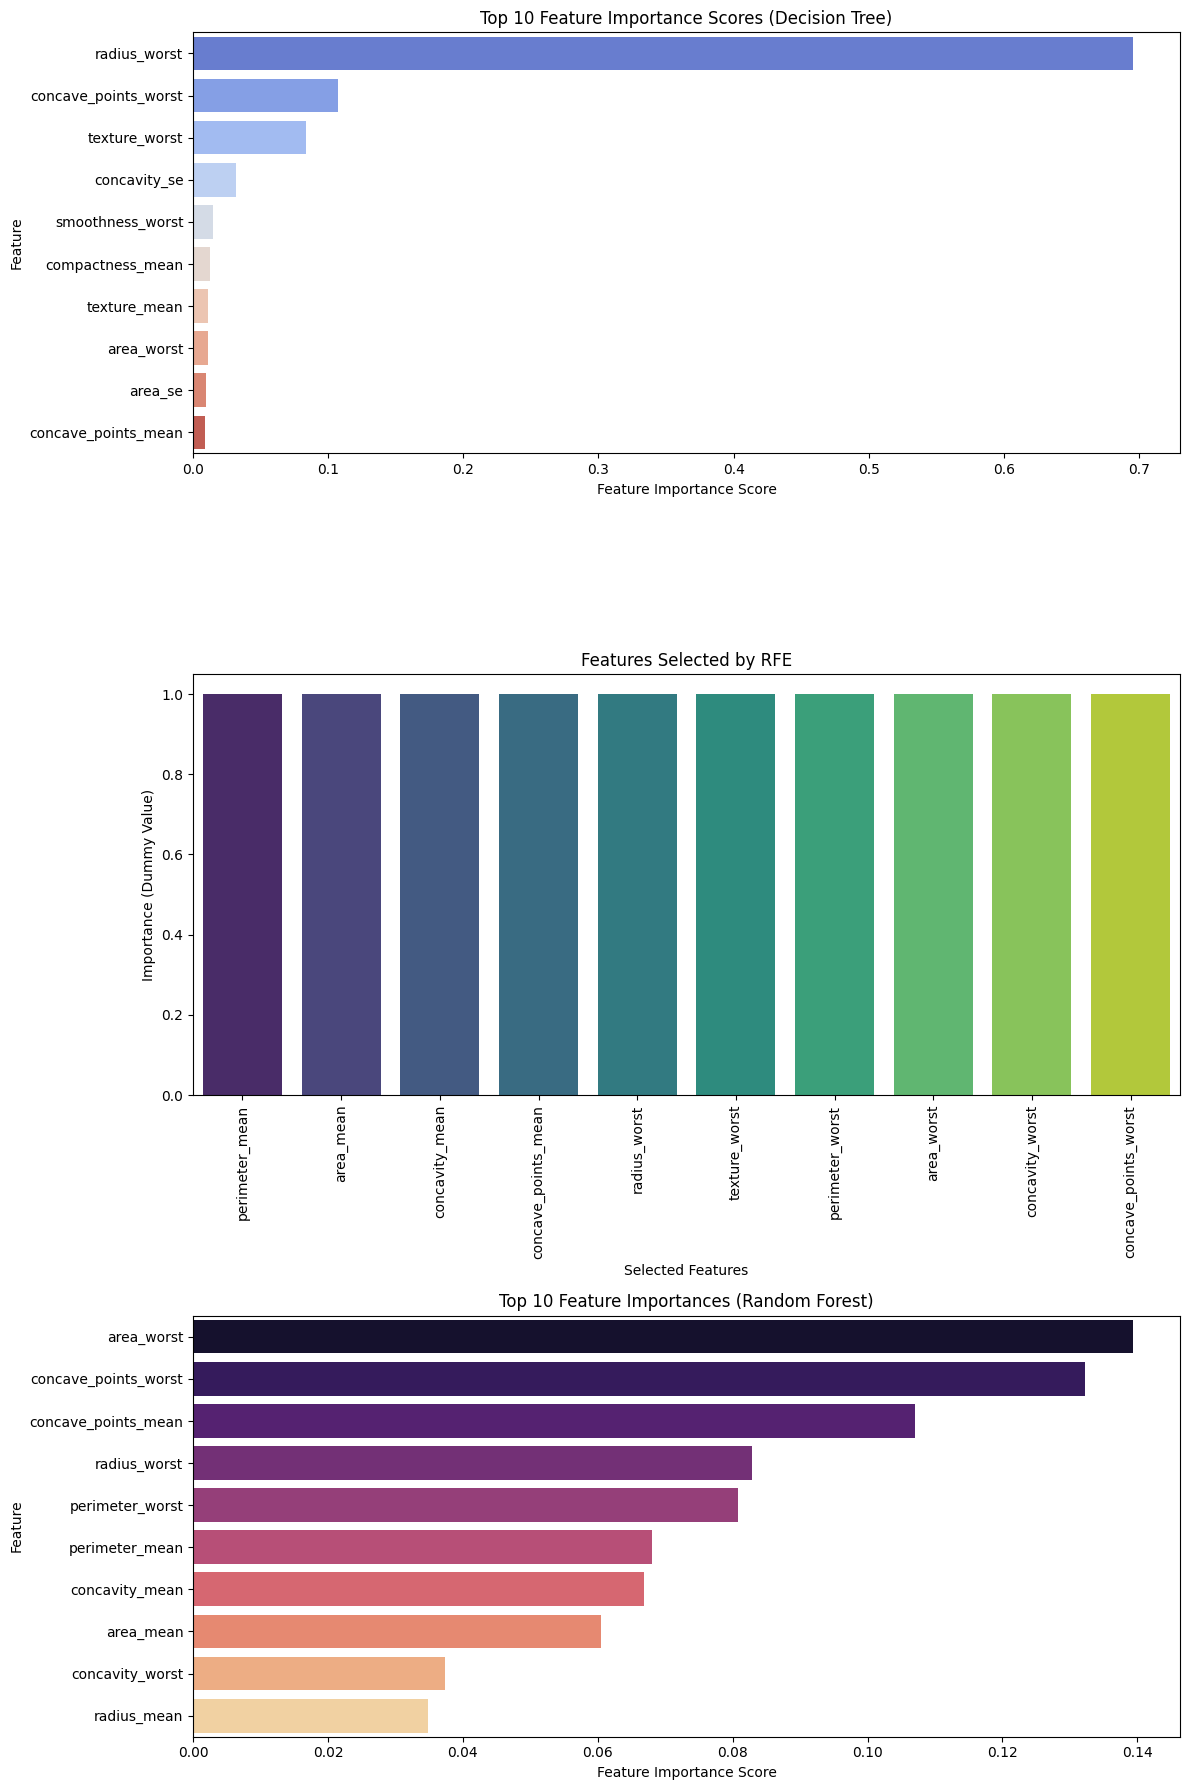

(['perimeter_mean',
  'area_mean',
  'concavity_mean',
  'concave_points_mean',
  'radius_worst',
  'texture_worst',
  'perimeter_worst',
  'area_worst',
  'concavity_worst',
  'concave_points_worst'],
                  Feature  Importance
 23            area_worst    0.139357
 27  concave_points_worst    0.132225
 7    concave_points_mean    0.107046
 20          radius_worst    0.082848
 22       perimeter_worst    0.080850
 2         perimeter_mean    0.067990
 6         concavity_mean    0.066917
 3              area_mean    0.060462
 26       concavity_worst    0.037339
 0            radius_mean    0.034843,
                  Feature  Importance
 20          radius_worst    0.695594
 27  concave_points_worst    0.107097
 21         texture_worst    0.083728
 16          concavity_se    0.031841
 24      smoothness_worst    0.014405
 5       compactness_mean    0.012530
 1           texture_mean    0.011277
 23            area_worst    0.011086
 13               area_se    0.009361

In [8]:


# ---------------------- Feature Selection using Random Forest ----------------------

# Define features and target variable
X_full = breast_cancer_data.drop(columns=["diagnosis"])
y = breast_cancer_data["diagnosis"]

# Train RandomForestClassifier to estimate feature importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_full, y)

# Perform Recursive Feature Elimination (RFE) to select the top 10 features
rfe = RFE(estimator=rf_model, n_features_to_select=10)
rfe.fit(X_full, y)

# Get the selected feature names
selected_features_rfe = X_full.columns[rfe.support_].tolist()

# Get feature importances from the RandomForest model
rf_feature_importances = pd.DataFrame(
    {"Feature": X_full.columns, "Importance": rf_model.feature_importances_}
).sort_values(by="Importance", ascending=False)

# ---------------------- Feature Importance using Decision Tree ----------------------

# Train a Decision Tree Classifier to get feature importance scores
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_full, y)

# Get feature importances from Decision Tree
dt_feature_importances = pd.DataFrame(
    {"Feature": X_full.columns, "Importance": dt_model.feature_importances_}
).sort_values(by="Importance", ascending=False)

# ---------------------- Visualization ----------------------

fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Plot feature importances from Decision Tree (Top 10)
sns.barplot(ax=axes[0], x=dt_feature_importances["Importance"].head(10), y=dt_feature_importances["Feature"].head(10), palette="coolwarm")
axes[0].set_xlabel("Feature Importance Score")
axes[0].set_ylabel("Feature")
axes[0].set_title("Top 10 Feature Importance Scores (Decision Tree)")

# Visualizing selected features from RFE
sns.barplot(ax=axes[1], x=selected_features_rfe, y=[1] * len(selected_features_rfe), palette="viridis")
axes[1].set_xlabel("Selected Features")
axes[1].set_ylabel("Importance (Dummy Value)")
axes[1].set_title("Features Selected by RFE")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)

# Visualizing feature importances from Random Forest (Top 10)
sns.barplot(ax=axes[2], x=rf_feature_importances["Importance"].head(10), y=rf_feature_importances["Feature"].head(10), palette="magma")
axes[2].set_xlabel("Feature Importance Score")
axes[2].set_ylabel("Feature")
axes[2].set_title("Top 10 Feature Importances (Random Forest)")

plt.tight_layout()
plt.show()

# ---------------------- Display Results ----------------------

selected_features_rfe, rf_feature_importances.head(10), dt_feature_importances.head(10)


In [9]:
# Ensure selected features are used
X_selected = breast_cancer_data[selected_features_rfe]
y = breast_cancer_data["diagnosis"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Apply standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Define models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}

# Perform cross-validation for each model
cv_results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="accuracy")
    cv_results[model_name] = {
        "Mean Accuracy": np.mean(scores),
        "Std Deviation": np.std(scores)
    }

# Convert results to DataFrame
cv_results_df = pd.DataFrame(cv_results).T

# Display results
print(cv_results_df)

                     Mean Accuracy  Std Deviation
Decision Tree             0.936264       0.023466
Logistic Regression       0.971429       0.017855
K-Nearest Neighbors       0.953846       0.036380


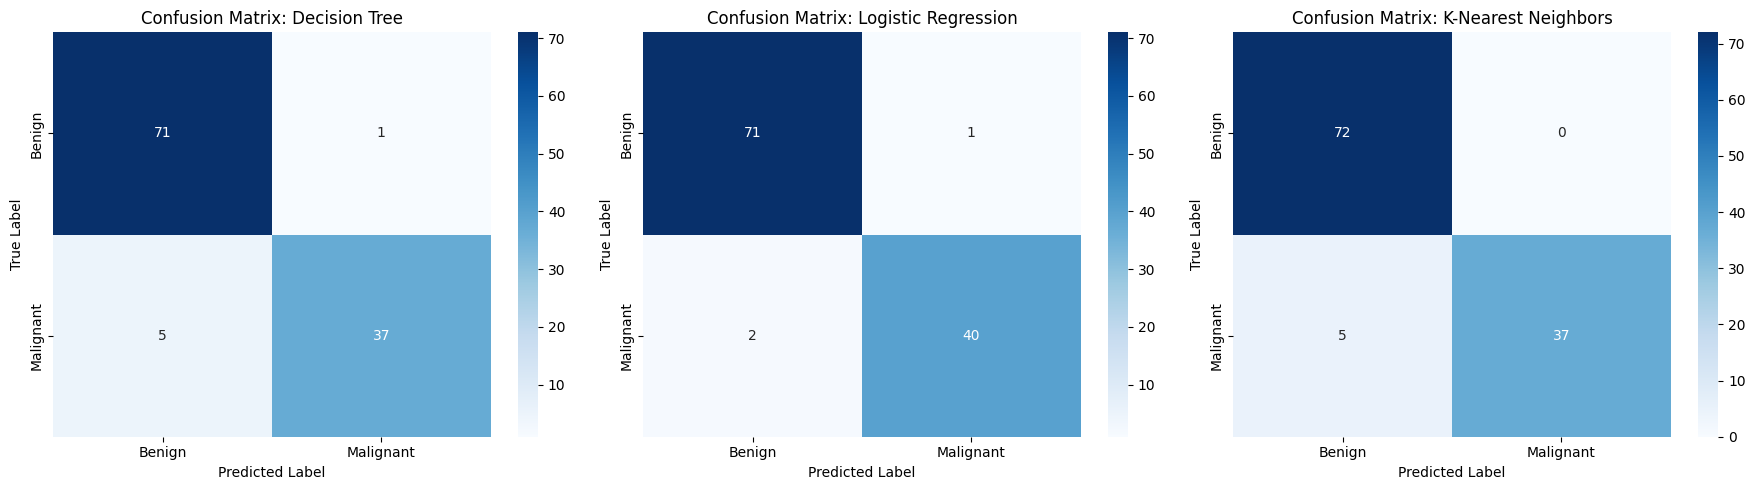

In [11]:

# Train models on the full training set
trained_models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42).fit(X_train_scaled, y_train),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42).fit(X_train_scaled, y_train),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5).fit(X_train_scaled, y_train)
}

# Evaluate each model on the test set and compute confusion matrices
confusion_matrices = {}
classification_reports = {}

for model_name, model in trained_models.items():
    y_pred = model.predict(X_test_scaled)
    confusion_matrices[model_name] = confusion_matrix(y_test, y_pred)
    classification_reports[model_name] = classification_report(y_test, y_pred, output_dict=True)

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (model_name, cm) in enumerate(confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"], ax=axes[i])
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")
    axes[i].set_title(f"Confusion Matrix: {model_name}")

plt.tight_layout()
plt.show()

# Convert classification reports to DataFrame for easy viewing
classification_reports_df = pd.concat({k: pd.DataFrame(v).T for k, v in classification_reports.items()}, axis=1)



In [12]:


# Convert classification reports to DataFrame
classification_reports_df = pd.concat({k: pd.DataFrame(v).T for k, v in classification_reports.items()}, axis=1)

# Print classification reports
print(classification_reports_df)
# Store previously computed classification reports
default_classification_reports = classification_reports  # From default models




             Decision Tree                                  \
                 precision    recall  f1-score     support   
0                 0.934211  0.986111  0.959459   72.000000   
1                 0.973684  0.880952  0.925000   42.000000   
accuracy          0.947368  0.947368  0.947368    0.947368   
macro avg         0.953947  0.933532  0.942230  114.000000   
weighted avg      0.948753  0.947368  0.946764  114.000000   

             Logistic Regression                                  \
                       precision    recall  f1-score     support   
0                       0.972603  0.986111  0.979310   72.000000   
1                       0.975610  0.952381  0.963855   42.000000   
accuracy                0.973684  0.973684  0.973684    0.973684   
macro avg               0.974106  0.969246  0.971583  114.000000   
weighted avg            0.973711  0.973684  0.973616  114.000000   

             K-Nearest Neighbors                                 
                      

In [13]:
# Define the range of k values to test
param_grid = {"n_neighbors": list(range(1, 21, 2))}  # Test odd values from 1 to 19

# Perform Grid Search with Cross-Validation
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train_scaled, y_train)

# Get the best k value
best_k = grid_search.best_params_["n_neighbors"]
print(f"Optimal k value: {best_k}")

# Train KNN with the best k
best_knn_model = KNeighborsClassifier(n_neighbors=best_k)
best_knn_model.fit(X_train_scaled, y_train)


Optimal k value: 11


KNeighborsClassifier(n_neighbors=11)

In [14]:


# Define parameter grid
param_grid_dt = {
    "max_depth": [3, 5, 10, None],  # Depth of the tree
    "min_samples_split": [2, 5, 10],  # Minimum samples to split a node
    "min_samples_leaf": [1, 2, 4],  # Minimum samples at a leaf node
    "criterion": ["gini", "entropy"],  # Splitting criterion
}

# Perform Grid Search with Cross-Validation
dt = DecisionTreeClassifier(random_state=42)
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring="accuracy")
grid_search_dt.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_dt_params = grid_search_dt.best_params_
print(f"Optimal Decision Tree Parameters: {best_dt_params}")

# Train the Decision Tree with the best hyperparameters
best_dt_model = DecisionTreeClassifier(**best_dt_params)
best_dt_model.fit(X_train_scaled, y_train)


Optimal Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}


DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=5)

In [15]:

# Define parameter grid
param_grid_lr = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    "penalty": ["l1", "l2"],  # Type of regularization
    "solver": ["liblinear", "saga"],  # Solvers that support both L1 & L2
}

# Perform Grid Search with Cross-Validation
lr = LogisticRegression(max_iter=1000, random_state=42)
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring="accuracy")
grid_search_lr.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_lr_params = grid_search_lr.best_params_
print(f"Optimal Logistic Regression Parameters: {best_lr_params}")

# Train Logistic Regression with the best hyperparameters
best_lr_model = LogisticRegression(**best_lr_params, max_iter=1000, random_state=42)
best_lr_model.fit(X_train_scaled, y_train)

Optimal Logistic Regression Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


LogisticRegression(C=10, max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')

After Hyperparameter tunning

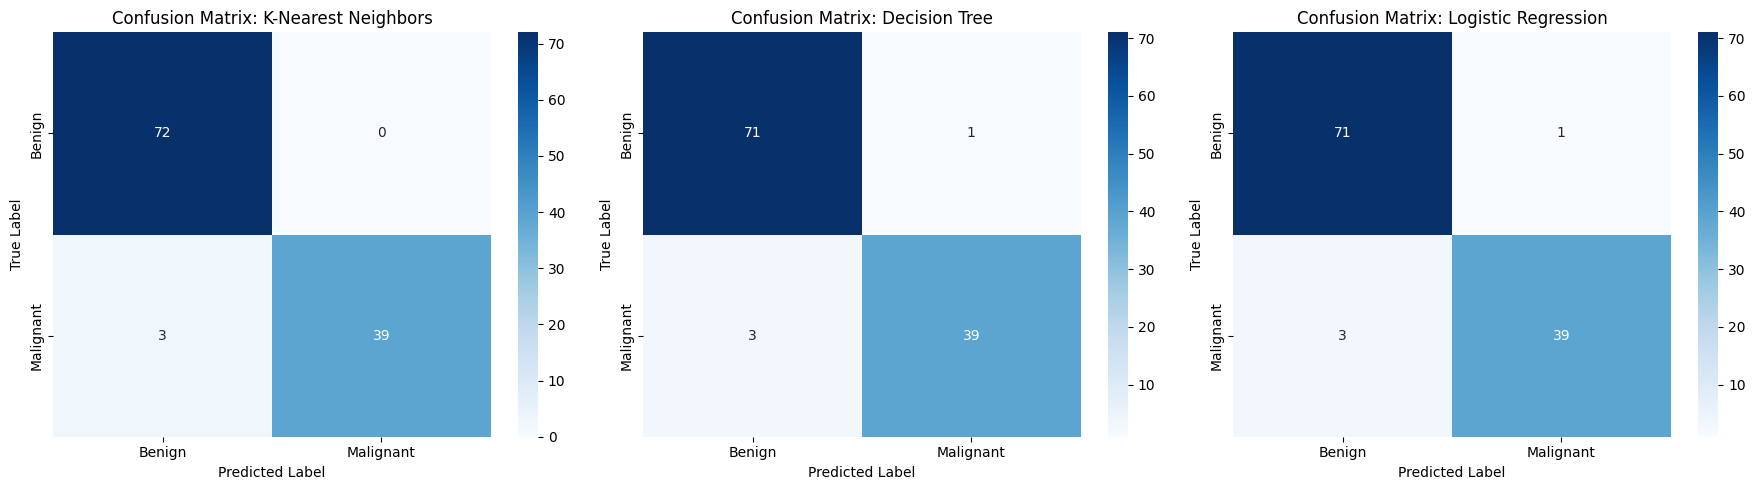

             K-Nearest Neighbors                                  \
                       precision    recall  f1-score     support   
0                       0.960000  1.000000  0.979592   72.000000   
1                       1.000000  0.928571  0.962963   42.000000   
accuracy                0.973684  0.973684  0.973684    0.973684   
macro avg               0.980000  0.964286  0.971277  114.000000   
weighted avg            0.974737  0.973684  0.973465  114.000000   

             Decision Tree                                  \
                 precision    recall  f1-score     support   
0                 0.959459  0.986111  0.972603   72.000000   
1                 0.975000  0.928571  0.951220   42.000000   
accuracy          0.964912  0.964912  0.964912    0.964912   
macro avg         0.967230  0.957341  0.961911  114.000000   
weighted avg      0.965185  0.964912  0.964725  114.000000   

             Logistic Regression                                  
                     

In [16]:


# Define final models with hypertuned parameters
final_models = {
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=11).fit(X_train_scaled, y_train),
    "Decision Tree": DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=5, random_state=42).fit(X_train_scaled, y_train),
    "Logistic Regression": LogisticRegression(C=10, penalty='l1', solver='liblinear', max_iter=1000, random_state=42).fit(X_train_scaled, y_train)
}

# Evaluate models
confusion_matrices = {}
classification_reports = {}

for model_name, model in final_models.items():
    y_pred = model.predict(X_test_scaled)
    confusion_matrices[model_name] = confusion_matrix(y_test, y_pred)
    classification_reports[model_name] = classification_report(y_test, y_pred, output_dict=True)

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, (model_name, cm) in enumerate(confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"], ax=axes[i])
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")
    axes[i].set_title(f"Confusion Matrix: {model_name}")

plt.tight_layout()
plt.show()

# Convert classification reports to DataFrame
import pandas as pd
classification_reports_df = pd.concat({k: pd.DataFrame(v).T for k, v in classification_reports.items()}, axis=1)

# Display classification reports
print(classification_reports_df)

tuned_classification_reports = classification_reports  # From tuned models


Learning Curves for Default Models


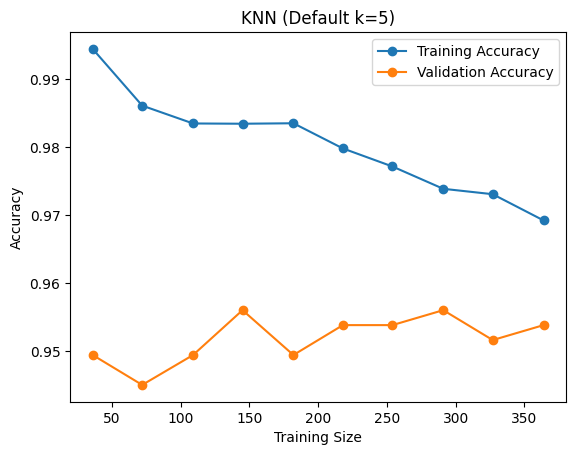

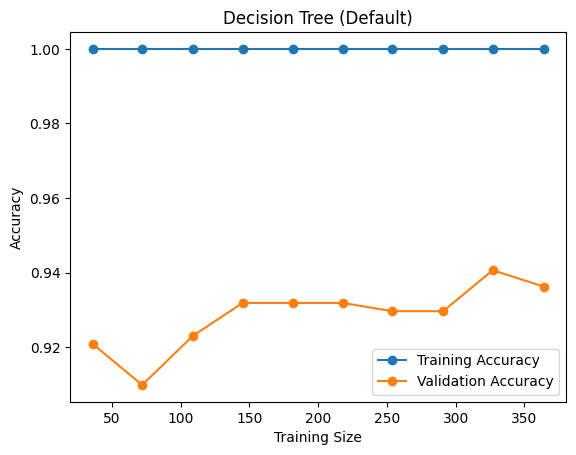

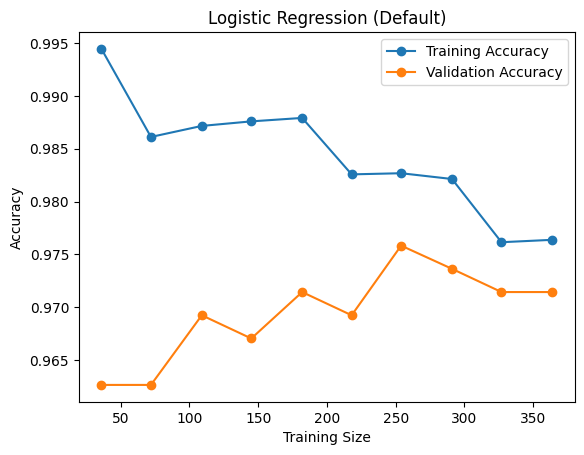

Learning Curves for Tuned Models


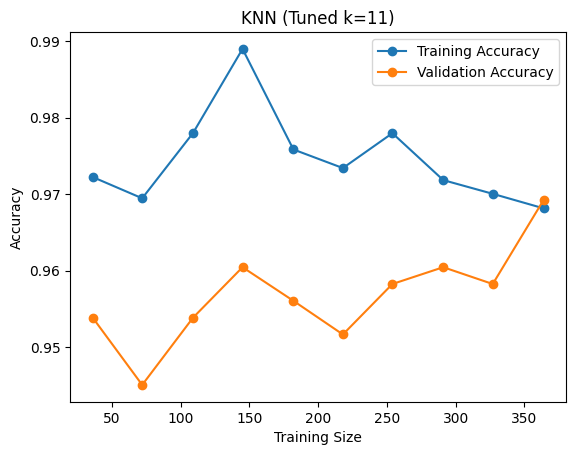

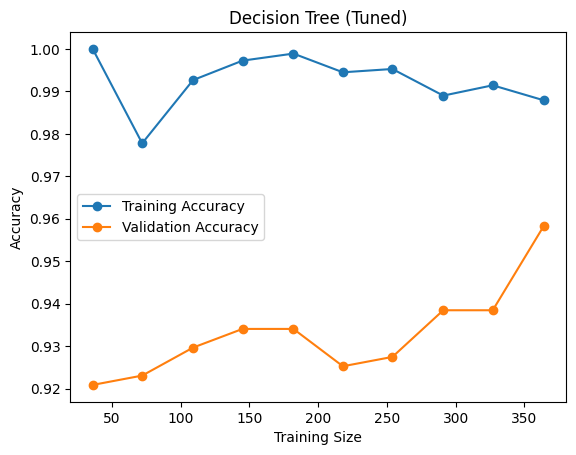

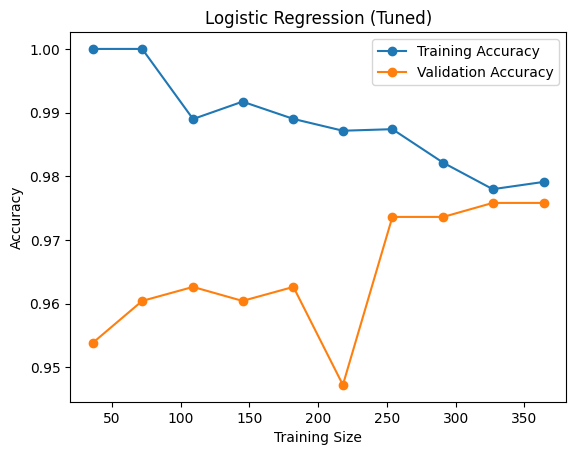

In [17]:


# Function to plot learning curves
def plot_learning_curve(model, title, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10))

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, 'o-', label="Training Accuracy")
    plt.plot(train_sizes, test_mean, 'o-', label="Validation Accuracy")

    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.show()

# Plot learning curves for default models
print("Learning Curves for Default Models")
plot_learning_curve(KNeighborsClassifier(n_neighbors=5), "KNN (Default k=5)", X_train_scaled, y_train)
plot_learning_curve(DecisionTreeClassifier(random_state=42), "Decision Tree (Default)", X_train_scaled, y_train)
plot_learning_curve(LogisticRegression(max_iter=1000, random_state=42), "Logistic Regression (Default)", X_train_scaled, y_train)

# Plot learning curves for tuned models
print("Learning Curves for Tuned Models")
plot_learning_curve(KNeighborsClassifier(n_neighbors=11), "KNN (Tuned k=11)", X_train_scaled, y_train)
plot_learning_curve(DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=5, random_state=42), "Decision Tree (Tuned)", X_train_scaled, y_train)
plot_learning_curve(LogisticRegression(C=10, penalty='l1', solver='liblinear', max_iter=1000, random_state=42), "Logistic Regression (Tuned)", X_train_scaled, y_train)


Based on the learning curve comparison between default and tuned models, I observed that the trends appear more balanced, particularly in the case of Decision Tree, followed by KNN.

This suggests that hyperparameter tuning has improved generalization, reducing overfitting while maintaining good performance. 

In [18]:
#print(default_reports_df.columns)  # Check available column names
#print(tuned_reports_df.columns)


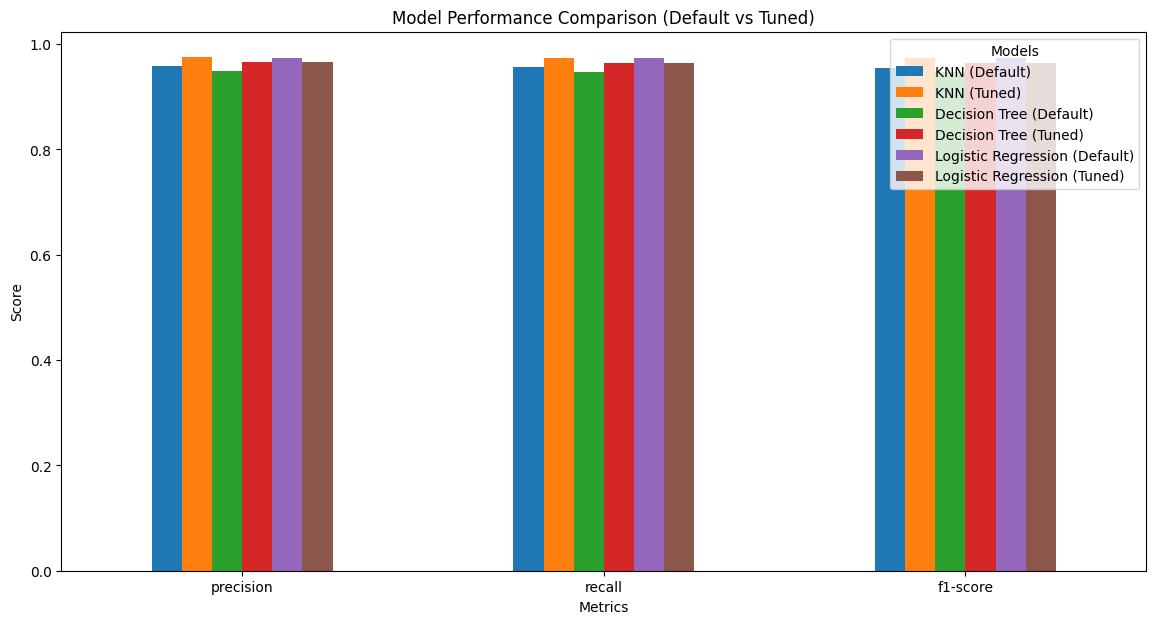

           KNN (Default)  KNN (Tuned)  Decision Tree (Default)  \
precision       0.958988     0.974737                 0.948753   
recall          0.956140     0.973684                 0.947368   
f1-score        0.955488     0.973465                 0.946764   

           Decision Tree (Tuned)  Logistic Regression (Default)  \
precision               0.965185                       0.973711   
recall                  0.964912                       0.973684   
f1-score                0.964725                       0.973616   

           Logistic Regression (Tuned)  
precision                     0.965185  
recall                        0.964912  
f1-score                      0.964725  


In [19]:


# Extract relevant metrics
metrics = ["precision", "recall", "f1-score"]

# Convert classification report dictionaries into DataFrames
default_reports_df = pd.DataFrame(default_classification_reports).T
tuned_reports_df = pd.DataFrame(tuned_classification_reports).T

# Extract "weighted avg" row and access dictionary values correctly
comparison_df = pd.DataFrame({
    "KNN (Default)": [float(default_reports_df.loc["K-Nearest Neighbors"]["weighted avg"][metric]) for metric in metrics],
    "KNN (Tuned)": [float(tuned_reports_df.loc["K-Nearest Neighbors"]["weighted avg"][metric]) for metric in metrics],
    "Decision Tree (Default)": [float(default_reports_df.loc["Decision Tree"]["weighted avg"][metric]) for metric in metrics],
    "Decision Tree (Tuned)": [float(tuned_reports_df.loc["Decision Tree"]["weighted avg"][metric]) for metric in metrics],
    "Logistic Regression (Default)": [float(default_reports_df.loc["Logistic Regression"]["weighted avg"][metric]) for metric in metrics],
    "Logistic Regression (Tuned)": [float(tuned_reports_df.loc["Logistic Regression"]["weighted avg"][metric]) for metric in metrics]
}, index=metrics)

# ---------------------- Visualization ----------------------
comparison_df.plot(kind="bar", figsize=(14, 7))
plt.title("Model Performance Comparison (Default vs Tuned)")
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(title="Models")
plt.show()

# Display comparison DataFrame
print(comparison_df)


In datasets like this, I consider recall as the best metric to consider followed by F1 score. Maximizing recall ensures that we don’t miss malignant cases, which is the highest priority in medical diagnosis.